In [258]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from transformers import transf as tf

In [259]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline

# Standard imports
import numpy as np
import pandas as pd
from collections import Counter, OrderedDict
import re
import string
import inspect
import os
import datetime
from sklearn.metrics import f1_score

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, precision_score, \
    recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, precision_score, recall_score,precision_recall_curve

from lightgbm import LGBMClassifier

from sklearn.metrics import confusion_matrix

# 1. Import data

## 1.1 Training data

In [260]:
df = pd.read_csv('data/train.csv')
df.head(2)

,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing,station
0,34d76816-cfc2-4bdd-b3a2-bf0c40b12689,Person search,2019-12-01T00:00:00+00:00,True,NaN,NaN,Male,18-24,Asian/Asian British - Any other Asian background,Asian,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,NaN,False,devon-and-cornwall
1,83c87ec1-e6d4-4bbb-8e0c-159516706359,Person search,2019-12-01T00:09:00+00:00,True,NaN,NaN,Male,18-24,NaN,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,NaN,False,devon-and-cornwall


## 1.2 Test set data 1

In [261]:
X_test_1 = pd.read_csv('data/X_test_1.csv')
X_test_1.head()

,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,station
0,3d931c84-94d3-4a14-869c-b10fef26e9ad,Person search,2020-01-01T00:56:00+00:00,False,NaN,NaN,Male,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,nottinghamshire
1,cf46ed6e-e6bb-4bc9-959d-ef2e5a8162a0,Person search,2020-01-01T01:45:00+00:00,False,NaN,NaN,Male,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,nottinghamshire
2,3601e51b-f40a-4466-b884-d9284497462c,Person search,2020-01-01T02:53:14+00:00,NaN,NaN,NaN,Male,18-24,Other ethnic group - Any other ethnic group,White,Police and Criminal Evidence Act 1984 (section 1),Stolen goods,city-of-london
3,95dae6a9-6775-4862-815f-61cf1b586384,Person search,2020-01-01T04:43:00+00:00,True,NaN,NaN,Female,18-24,Other ethnic group - Not stated,Mixed,Misuse of Drugs Act 1971 (section 23),Controlled drugs,nottinghamshire
4,467c4766-3a3f-489d-bf09-5a698748499e,Person search,2020-01-01T05:08:30+00:00,NaN,51.512598,-0.084967,Male,10-17,Other ethnic group - Not stated,Black,Misuse of Drugs Act 1971 (section 23),Controlled drugs,city-of-london


In [262]:
y_test_1 = pd.read_csv('data/y_test_1.csv')
y_test_1.head()

,observation_id,0
0,3d931c84-94d3-4a14-869c-b10fef26e9ad,False
1,cf46ed6e-e6bb-4bc9-959d-ef2e5a8162a0,False
2,3601e51b-f40a-4466-b884-d9284497462c,False
3,95dae6a9-6775-4862-815f-61cf1b586384,False
4,467c4766-3a3f-489d-bf09-5a698748499e,False


In [263]:
# My own predictions in this fase
predictions_test_1 = pd.read_csv('data/predictions_test1.csv').drop(columns=['observation','true_outcome','id']).rename(columns={'outcome':'predicted_outcome'})
predictions_test_1.head(2)

,observation_id,predicted_outcome
0,cf46ed6e-e6bb-4bc9-959d-ef2e5a8162a0,False
1,3601e51b-f40a-4466-b884-d9284497462c,False


## 1.3 Test set data 2

In [264]:
X_test_2 = pd.read_csv('data/X_test_2.csv')
column_order = ['observation_id', 'Type', 'Date', 'Part of a policing operation',
       'Latitude', 'Longitude', 'Gender', 'Age range',
       'Self-defined ethnicity', 'Officer-defined ethnicity', 'Legislation',
       'Object of search', 'station']
print(X_test_2.columns)

from ast import literal_eval

observation_data = X_test_2['observation'].map(literal_eval).apply(pd.Series)
X_test_2 = pd.concat([X_test_2, observation_data], axis=1).drop( columns=['observation'])

print(X_test_2.columns)

# X_test_2 = X_test_2.reindex(columns=column_order)

print(X_test_2.columns)
df_2 = X_test_2.copy()

Index(['id', 'observation_id', 'observation', 'outcome', 'true_outcome'], dtype='object')
Index(['id', 'observation_id', 'outcome', 'true_outcome', 'Type', 'Date',
       'Part of a policing operation', 'Latitude', 'Longitude', 'Gender',
       'Age range', 'Officer-defined ethnicity', 'Legislation',
       'Object of search', 'station'],
      dtype='object')
Index(['id', 'observation_id', 'outcome', 'true_outcome', 'Type', 'Date',
       'Part of a policing operation', 'Latitude', 'Longitude', 'Gender',
       'Age range', 'Officer-defined ethnicity', 'Legislation',
       'Object of search', 'station'],
      dtype='object')


In [265]:
df_2.outcome.value_counts()

False    3926
True       77
Name: outcome, dtype: int64

# 2. Pipeline and merge datasets

In [266]:
target_pipe =  Pipeline(
    steps=[
            ('Filter Metropolitain', tf.Filter_ColumnValue(col='station', value='metropolitan')),
            ('FixNA_OutcomeLinkedSearch', tf.FixNA_OutcomeLinkedSearch()), 
            ('OutcomePositive', tf.Mask_OutcomePositive()),
            ('SearchSuccess', tf.Mask_SearchSuccess()),
            ])

In [267]:
initial_pipe = Pipeline(
    steps=[
            ('Filter Metropolitain', tf.Filter_ColumnValue(col='station', value='metropolitan')),
            ('FixNA_Coordinates', tf.FixNA_Coordinates()),
            ('DateTransformer', tf.DateTransformer())
            ])

In [268]:
df =  target_pipe.fit_transform(df)
df = df.drop(columns=['Outcome', 'Outcome linked to object of search','Removal of more than just outer clothing', 'outcome_positive'])

In [269]:
df_1 = pd.concat([X_test_1,y_test_1.drop(columns=['observation_id'])], axis=1) \
                                    .rename(columns={ '0':'search_success'}) 

In [270]:
df_1 = pd.merge(df_1, predictions_test_1, on='observation_id')

In [271]:
df_final = pd.concat([df, df_1])

In [272]:
df_final =  initial_pipe.fit_transform(df_final)

In [273]:
df =  initial_pipe.fit_transform(df)
df_1 =  initial_pipe.fit_transform(df_1)
df_2 =  initial_pipe.fit_transform(df_2)

In [274]:
# obsservations ins both test sets

In [275]:
df_test_intersection = pd.merge(df_1, df_2[['observation_id', 'outcome']], on='observation_id', how='inner').rename(columns={'predicted_outcome':'predicted_outcome_test1','outcome':'predicted_outcome_test2'})

# 3. Basis analysis on dimensions

### 1. Object of search

In [276]:
df.columns

Index(['observation_id', 'Type', 'Date', 'Part of a policing operation',
       'Latitude', 'Longitude', 'Gender', 'Age range',
       'Self-defined ethnicity', 'Officer-defined ethnicity', 'Legislation',
       'Object of search', 'station', 'search_success', 'Day', 'Hour',
       'Minute', 'Time (sin)', 'Time (cos)'],
      dtype='object')

                              Object of search  observation_id
0          Anything to threaten or harm anyone        1.706340
1                     Article for use in theft        9.969061
2          Articles for use in criminal damage        2.114012
3                             Controlled drugs       62.980373
4                                    Crossbows        0.005496
5        Detailed object of search unavailable        0.041705
6           Evidence of offences under the Act        0.623955
7                Evidence of wildlife offences        0.008082
8                                     Firearms        0.975375
9                                    Fireworks        0.553478
10                  Game or poaching equipment        0.032976
11  Goods on which duty has not been paid etc.        0.007436
12                           Offensive weapons       11.688656
13                     Psychoactive substances        0.549921
14                  Seals or hunting equipment        0

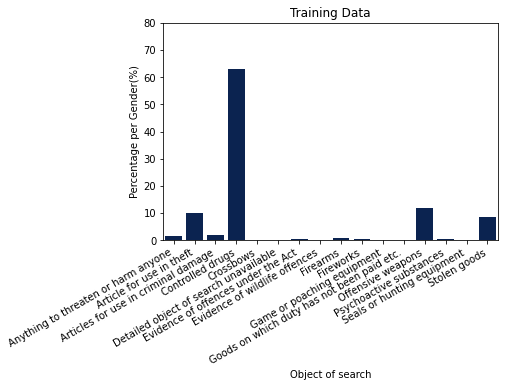

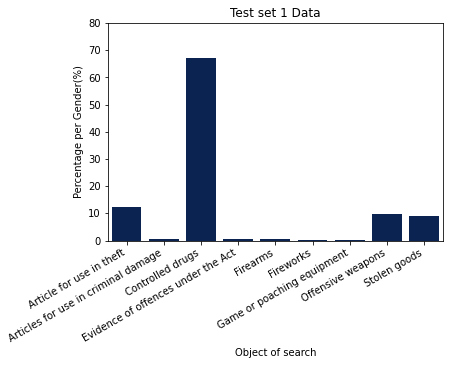

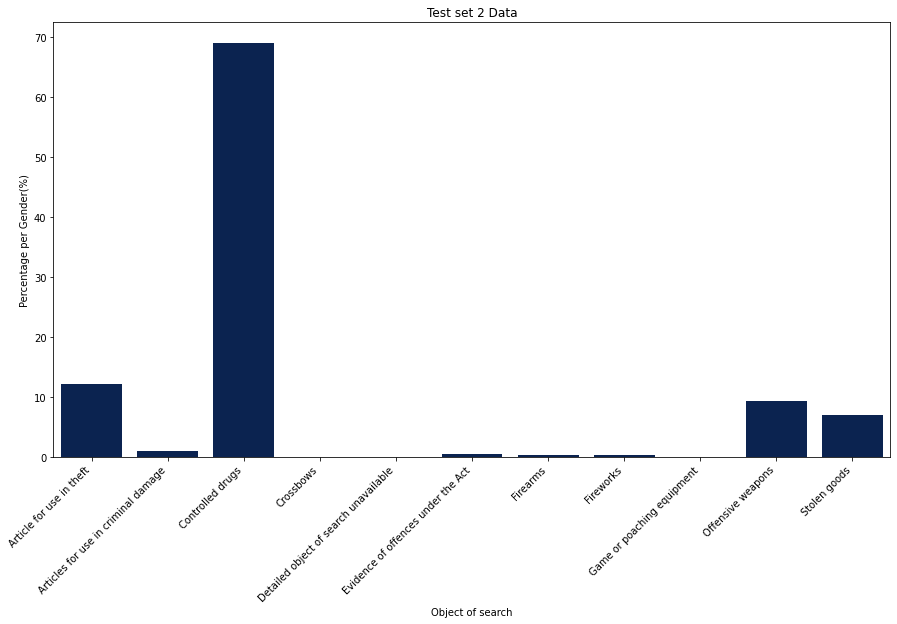

In [277]:
column_analysed = 'Object of search'
#train
data_ = (df.groupby(column_analysed)['observation_id'].count()/df['observation_id'].count() * 100).reset_index()
print(data_)
f, ax = plt.subplots()
sns.barplot(x=column_analysed, y='observation_id', data=data_, color="#001f5b", orient='v')
ax.set(ylabel="Percentage per Gender(%)",xlabel=column_analysed)
ax.set_title('Training Data')
ax.set(ylim=(0, 80))
# ax.xticks(rotation=45)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30,horizontalalignment='right')
f.show()

#test 1
data_ = (df_1.groupby(column_analysed)['observation_id'].count()/df_1['observation_id'].count() * 100).reset_index()
print(data_)
f, ax = plt.subplots()
sns.barplot(x=column_analysed, y='observation_id', data=data_, color="#001f5b", orient='v')
ax.set(ylabel="Percentage per Gender(%)",xlabel=column_analysed )
ax.set_title('Test set 1 Data')
ax.set(ylim=(0, 80))
ax.set_xticklabels(ax.get_xticklabels(),rotation=30,horizontalalignment='right')
f.show()

#test 2
data_ = (df_2.groupby(column_analysed)['observation_id'].count()/df_2['observation_id'].count() * 100).reset_index()
print(data_)
f, ax = plt.subplots(figsize=(15, 8))
sns.barplot(x=column_analysed, y='observation_id', data=data_, color="#001f5b", orient='v')
ax.set(ylabel="Percentage per Gender(%)",xlabel=column_analysed )
ax.set_title('Test set 2 Data')
plt.setp(ax.get_xticklabels(), rotation=45,horizontalalignment='right')
f.show()

### 2. Age

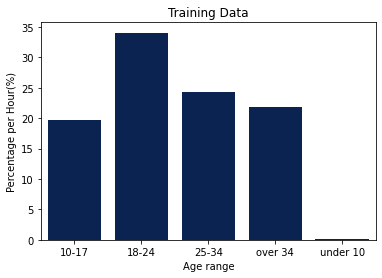

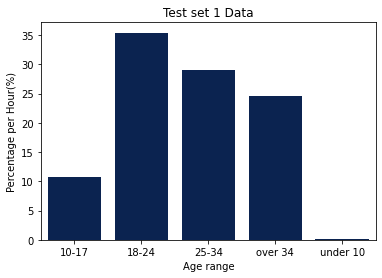

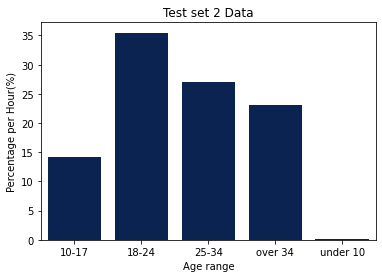

In [278]:
column_analysed = 'Age range'
#train
data_gender = (df.groupby(column_analysed)['observation_id'].count()/df['observation_id'].count() * 100).reset_index()
f, ax = plt.subplots()
sns.barplot(x=column_analysed, y='observation_id', data=data_gender, color="#001f5b", orient='v')
ax.set(ylabel="Percentage per Hour(%)",xlabel=column_analysed)
ax.set_title('Training Data')
f.show()

#test 1
data_gender = (df_1.groupby(column_analysed)['observation_id'].count()/df_1['observation_id'].count() * 100).reset_index()
f, ax = plt.subplots()
sns.barplot(x=column_analysed, y='observation_id', data=data_gender, color="#001f5b", orient='v')
ax.set(ylabel="Percentage per Hour(%)",xlabel=column_analysed )
ax.set_title('Test set 1 Data')
f.show()

#test 2
data_gender = (df_2.groupby(column_analysed)['observation_id'].count()/df_2['observation_id'].count() * 100).reset_index()
f, ax = plt.subplots()
sns.barplot(x=column_analysed, y='observation_id', data=data_gender, color="#001f5b", orient='v')
ax.set(ylabel="Percentage per Hour(%)",xlabel=column_analysed )
ax.set_title('Test set 2 Data')
f.show()

### 2. Hour

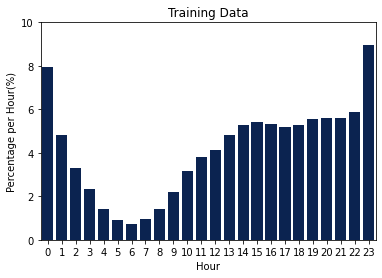

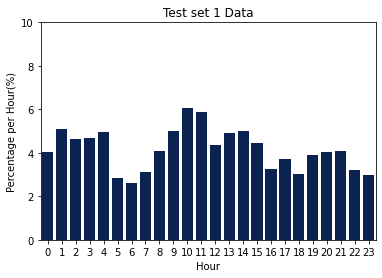

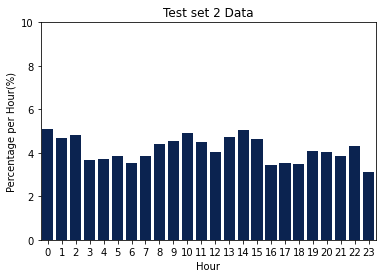

In [326]:
column_analysed = 'Hour'
#train
data_gender = df.dropna(subset=['Hour'])
data_gender.Hour = data_gender.Hour.astype(int)
data_gender = (data_gender.groupby(column_analysed)['observation_id'].count()/data_gender['observation_id'].count() * 100).reset_index()
f, ax = plt.subplots()
sns.barplot(x=column_analysed, y='observation_id', data=data_gender, color="#001f5b", orient='v')
ax.set(ylabel="Percentage per Hour(%)",xlabel=column_analysed)
ax.set_title('Training Data')
ax.set(ylim=(0, 10))
f.show()




#test 1
data_gender = (df_1.groupby(column_analysed)['observation_id'].count()/df_1['observation_id'].count() * 100).reset_index()
f, ax = plt.subplots()
sns.barplot(x=column_analysed, y='observation_id', data=data_gender, color="#001f5b", orient='v')
ax.set(ylabel="Percentage per Hour(%)",xlabel=column_analysed )
ax.set_title('Test set 1 Data')
ax.set(ylim=(0, 10))
f.show()

#test 2
data_gender = (df_2.groupby(column_analysed)['observation_id'].count()/df_2['observation_id'].count() * 100).reset_index()
f, ax = plt.subplots()
sns.barplot(x=column_analysed, y='observation_id', data=data_gender, color="#001f5b", orient='v')
ax.set(ylabel="Percentage per Hour(%)",xlabel=column_analysed )
ax.set_title('Test set 2 Data')
ax.set(ylim=(0, 10))
f.show()

In [280]:
### 3. Ethinicity

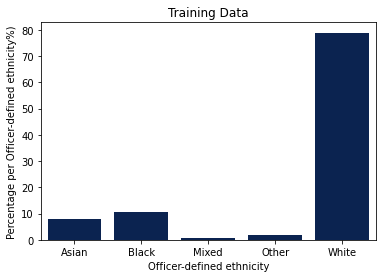

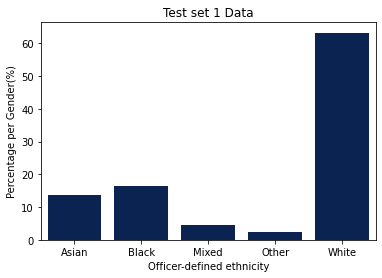

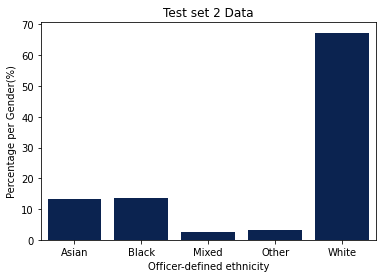

In [281]:
column_analysed = 'Officer-defined ethnicity'
#train
data_gender = (df.groupby(column_analysed)['observation_id'].count()/df['observation_id'].count() * 100).reset_index()
f, ax = plt.subplots()
sns.barplot(x=column_analysed, y='observation_id', data=data_gender, color="#001f5b", orient='v')
ax.set(ylabel="Percentage per Officer-defined ethnicity%)",xlabel=column_analysed)
ax.set_title('Training Data')
f.show()

#test 1
data_gender = (df_1.groupby(column_analysed)['observation_id'].count()/df_1['observation_id'].count() * 100).reset_index()
f, ax = plt.subplots()
sns.barplot(x=column_analysed, y='observation_id', data=data_gender, color="#001f5b", orient='v')
ax.set(ylabel="Percentage per Gender(%)",xlabel=column_analysed )
ax.set_title('Test set 1 Data')
f.show()

#test 2
data_gender = (df_2.groupby(column_analysed)['observation_id'].count()/df_2['observation_id'].count() * 100).reset_index()
f, ax = plt.subplots()
sns.barplot(x=column_analysed, y='observation_id', data=data_gender, color="#001f5b", orient='v')
ax.set(ylabel="Percentage per Gender(%)",xlabel=column_analysed )
ax.set_title('Test set 2 Data')
f.show()

In [282]:
### 4. station - only 4 stations in the test set 1 and 2. We had no previous info that only 4 stations would be used for test. Neither that the same stations would be used in both test set.

In [283]:
df.station.isin(['cambridgeshire','city-of-london','durham','nottinghamshire'])

0         False
1         False
2         False
3         False
4         False
          ...  
309312    False
309313    False
309314    False
309315    False
309316    False
Name: station, Length: 309317, dtype: bool

           station  observation_id
0   cambridgeshire        6.118747
1   city-of-london       24.942441
2           durham       19.381846
3  nottinghamshire       49.556966
           station  observation_id
0   cambridgeshire           0.775
1   city-of-london          31.800
2           durham          12.350
3  nottinghamshire          55.075
           station  observation_id
0   cambridgeshire       16.612541
1   city-of-london       29.452910
2           durham        9.318011
3  nottinghamshire       44.616538


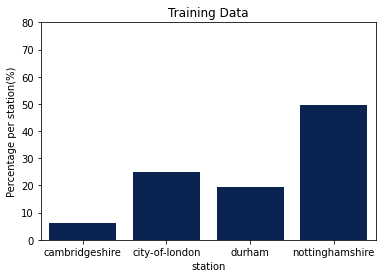

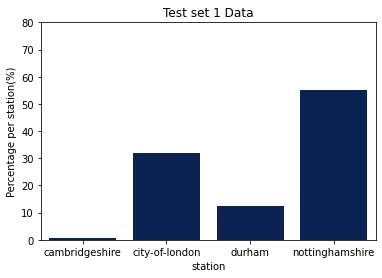

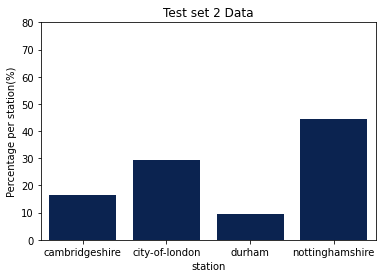

In [284]:
column_analysed = 'station'
#train
df_filterstations = df[df.station.isin(['cambridgeshire','city-of-london','durham','nottinghamshire'])]

data_gender = (df_filterstations.groupby(column_analysed)['observation_id'].count()/df_filterstations['observation_id'].count() * 100).reset_index()

print(data_gender)
f, ax = plt.subplots()
sns.barplot(x=column_analysed, y='observation_id', data=data_gender, color="#001f5b", orient='v')
ax.set(ylabel="Percentage per station(%)",xlabel=column_analysed)
ax.set_title('Training Data')
ax.set(ylim=(0, 80))
f.show()

#test 1
data_gender = (df_1.groupby(column_analysed)['observation_id'].count()/df_1['observation_id'].count() * 100).reset_index()
print(data_gender)
f, ax = plt.subplots()
sns.barplot(x=column_analysed, y='observation_id', data=data_gender, color="#001f5b", orient='v')
ax.set(ylabel="Percentage per station(%)",xlabel=column_analysed )
ax.set_title('Test set 1 Data')
ax.set(ylim=(0, 80))
f.show()

#test 2
data_gender = (df_2.groupby(column_analysed)['observation_id'].count()/df_2['observation_id'].count() * 100).reset_index()
print(data_gender)
f, ax = plt.subplots()
sns.barplot(x=column_analysed, y='observation_id', data=data_gender, color="#001f5b", orient='v')
ax.set(ylabel="Percentage per station(%)",xlabel=column_analysed )
ax.set_title('Test set 2 Data')
ax.set(ylim=(0, 80))
f.show()

# 4. Success outcomes analysis

Text(0.5, 1.0, 'Test set 1 Data')

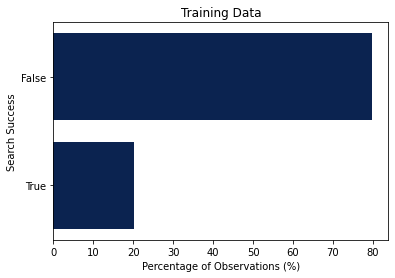

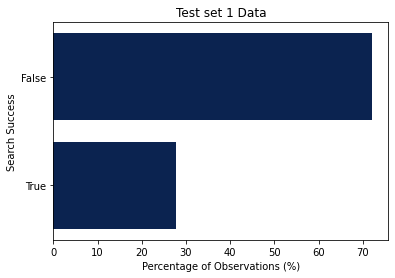

In [285]:
data_sucess_outcomes = df.groupby('search_success')['observation_id'].count()/df['observation_id'].count() * 100
data_sucess_outcomes = pd.DataFrame(data_sucess_outcomes).reset_index()
data_sucess_outcomes

f, ax = plt.subplots()
sns.barplot(y='search_success', x='observation_id',  data=data_sucess_outcomes, color="#001f5b", orient='h')
ax.set(xlabel="Percentage of Observations (%)",ylabel="Search Success" )
ax.set_title('Training Data')


data_sucess_outcomes = df_1.groupby('search_success')['observation_id'].count()/df_1['observation_id'].count() * 100
data_sucess_outcomes = pd.DataFrame(data_sucess_outcomes).reset_index()
data_sucess_outcomes

f, ax = plt.subplots()
sns.barplot(y='search_success', x='observation_id',  data=data_sucess_outcomes, color="#001f5b", orient='h')
ax.set(xlabel="Percentage of Observations (%)",ylabel="Search Success" )
ax.set_title('Test set 1 Data')

Text(0.5, 1.0, 'Test set 1 Data')

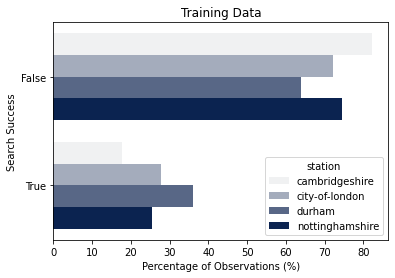

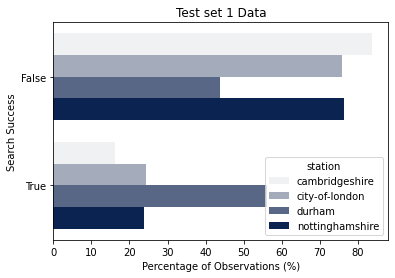

In [286]:
df_filterstations = df[df.station.isin(['cambridgeshire','city-of-london','durham','nottinghamshire'])]

data_sucess_outcomes = df_filterstations.groupby(['search_success', 'station'])['observation_id'].count()/df_filterstations.groupby(['station'])['observation_id'].count() * 100
data_sucess_outcomes = pd.DataFrame(data_sucess_outcomes).reset_index()
data_sucess_outcomes

f, ax = plt.subplots()
sns.barplot(y='search_success', x='observation_id',hue='station',  data=data_sucess_outcomes, color="#001f5b", orient='h')
ax.set(xlabel="Percentage of Observations (%)",ylabel="Search Success" )
ax.set_title('Training Data')

df_1_filterstations = df_1[df_1.station.isin(['cambridgeshire','city-of-london','durham','nottinghamshire'])]
data_sucess_outcomes = df_1.groupby(['search_success', 'station'])['observation_id'].count()/df_1_filterstations.groupby(['station'])['observation_id'].count() * 100
data_sucess_outcomes = pd.DataFrame(data_sucess_outcomes).reset_index()
data_sucess_outcomes

f, ax = plt.subplots()
sns.barplot(y='search_success', x='observation_id', hue='station',  data=data_sucess_outcomes, color="#001f5b", orient='h')
ax.set(xlabel="Percentage of Observations (%)",ylabel="Search Success" )
ax.set_title('Test set 1 Data')

Text(0.5, 1.0, 'Test set 1')

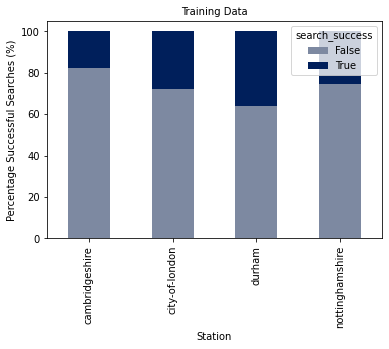

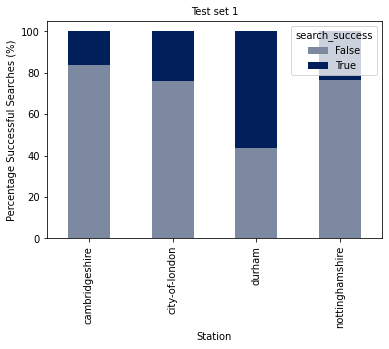

In [287]:
sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True)
df_plot = df_filterstations.groupby(['search_success', 'station']).size().reset_index().pivot(columns='search_success', index='station', values=0)
df_plot_graphic[False] = df_plot[False]/(df_plot[False]+df_plot[True])*100
df_plot_graphic[True] = df_plot[True]/(df_plot[False]+df_plot[True])*100
df_plot_graphic.plot(kind='bar', stacked=True, color=["#7d89a1","#001f5b" ])
plt.ylabel("Percentage Successful Searches (%)", fontsize=10)
plt.xlabel("Station", fontsize=10)
plt.title('Training Data', fontsize=10) 


df_plot_1 = df_1_filterstations.groupby(['search_success', 'station']).size().reset_index().pivot(columns='search_success', index='station', values=0)
df_plot_1_graphic[False] = df_plot_1[False]/(df_plot_1[False]+df_plot_1[True])*100
df_plot_1_graphic[True] = df_plot_1[True]/(df_plot_1[False]+df_plot_1[True])*100
df_plot_1_graphic.plot(kind='bar', stacked=True , color=["#7d89a1","#001f5b" ])
plt.ylabel("Percentage Successful Searches (%)", fontsize=10)
plt.xlabel("Station", fontsize=10)
plt.title('Test set 1', fontsize=10) 



Text(0.5, 1.0, 'Training Data')

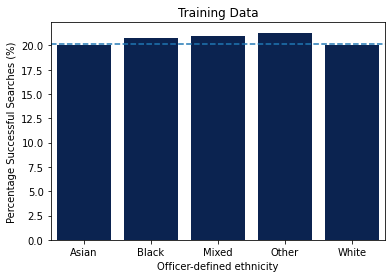

In [288]:
data_sucess_outcomes = df.groupby(['Officer-defined ethnicity','search_success'])['observation_id'].count()/df.groupby(['Officer-defined ethnicity'])['observation_id'].count() * 100
data_sucess_outcomes = pd.DataFrame(data_sucess_outcomes).reset_index()
data_sucess_outcomes = data_sucess_outcomes[data_sucess_outcomes['search_success']==True]


f, ax = plt.subplots()
sns.barplot(x='Officer-defined ethnicity', y='observation_id', data=data_sucess_outcomes, color="#001f5b", orient='v')
ax.axhline(20.1, ls='--')
ax.set(ylabel="Percentage Successful Searches (%)",xlabel="Officer-defined ethnicity" )
ax.set_title('Training Data')

In [321]:
data_sucess_outcomes.Hour.astype(int)

1      0
3      1
5      2
7      3
9      4
11     5
13     6
15     7
17     8
19     9
21    10
23    11
25    12
27    13
29    14
31    15
33    16
35    17
37    18
39    19
41    20
43    21
45    22
47    23
Name: Hour, dtype: int32

    Hour  search_success  observation_id
1      0            True       19.737973
3      1            True       18.602442
5      2            True       18.001969
7      3            True       16.466030
9      4            True       16.920975
11     5            True       19.500724
13     6            True       22.884440
15     7            True       20.962786
17     8            True       21.536697
19     9            True       20.138684
21    10            True       21.645998
23    11            True       21.355060
25    12            True       21.330693
27    13            True       20.877335
29    14            True       21.187327
31    15            True       20.468572
33    16            True       20.186297
35    17            True       20.006275
37    18            True       20.524396
39    19            True       19.976498
41    20            True       20.451241
43    21            True       20.684058
45    22            True       21.068694
47    23        

Text(0.5, 1.0, 'Training Data')

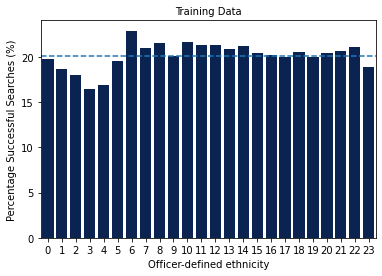

In [324]:
#perc success por ethinicty variencia por hora
data_sucess_outcomes = df.dropna(subset=['Hour'])
data_sucess_outcomes.Hour = data_sucess_outcomes.Hour.astype(int)
data_sucess_outcomes = data_sucess_outcomes.groupby(['Hour','search_success'])['observation_id'].count()/data_sucess_outcomes.groupby(['Hour'])['observation_id'].count() * 100
data_sucess_outcomes = pd.DataFrame(data_sucess_outcomes).reset_index()
data_sucess_outcomes = data_sucess_outcomes[data_sucess_outcomes['search_success']==True]
print(data_sucess_outcomes)

f, ax = plt.subplots()
sns.barplot(x='Hour', y='observation_id', data=data_sucess_outcomes, color="#001f5b", orient='v')
ax.axhline(20.1, ls='--')
ax.set(ylabel="Percentage Successful Searches (%)",xlabel="Officer-defined ethnicity" )

data_sucess_outcomes = df.dropna(subset=['Hour'])
data_sucess_outcomes.Hour = data_sucess_outcomes.Hour.astype(int)
ax.set(ylim=(0, 40))
plt.title('Training Data', fontsize=10) 

    Hour  search_success  observation_id
1      0            True       27.950311
3      1            True       24.509804
5      2            True       28.494624
7      3            True       24.598930
9      4            True       20.100503
11     5            True       25.663717
13     6            True       20.000000
15     7            True       24.800000
17     8            True       27.439024
19     9            True       26.500000
21    10            True       27.272727
23    11            True       36.595745
25    12            True       37.714286
27    13            True       28.571429
29    14            True       27.860697
31    15            True       28.651685
33    16            True       32.061069
35    17            True       33.557047
37    18            True       23.140496
39    19            True       28.846154
41    20            True       22.222222
43    21            True       25.766871
45    22            True       28.125000
47    23        

Text(0.5, 1.0, 'Test set 1')

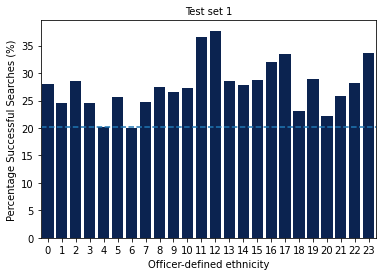

In [320]:
#perc success por ethinicty variencia por género
data_sucess_outcomes = df_1.groupby(['Hour','search_success'])['observation_id'].count()/df_1.groupby(['Hour'])['observation_id'].count() * 100
data_sucess_outcomes = pd.DataFrame(data_sucess_outcomes).reset_index()
data_sucess_outcomes = data_sucess_outcomes[data_sucess_outcomes['search_success']==True]
print(data_sucess_outcomes )

f, ax = plt.subplots()
sns.barplot(x='Hour', y='observation_id', data=data_sucess_outcomes, color="#001f5b", orient='v')
ax.axhline(20.1, ls='--')
ax.set(ylabel="Percentage Successful Searches (%)",xlabel="Officer-defined ethnicity" )
plt.title('Test set 1', fontsize=10) 

[Text(0, 0.5, 'Percentage Successful Searches (%)'),
 Text(0.5, 0, 'Officer-defined ethnicity')]

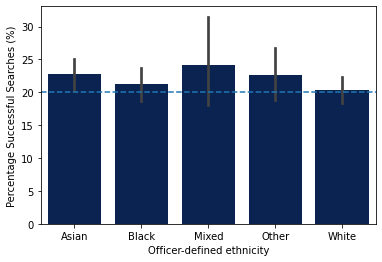

In [291]:
#perc success por ethinicty variencia por género
data_sucess_outcomes = df.groupby(['Officer-defined ethnicity','station','search_success'])['observation_id'].count()/df.groupby(['Officer-defined ethnicity','station'])['observation_id'].count() * 100
data_sucess_outcomes = pd.DataFrame(data_sucess_outcomes).reset_index()
data_sucess_outcomes = data_sucess_outcomes[data_sucess_outcomes['search_success']==True]


f, ax = plt.subplots()
sns.barplot(x='Officer-defined ethnicity', y='observation_id', data=data_sucess_outcomes, color="#001f5b", orient='v')
ax.axhline(20.1, ls='--')
ax.set(ylabel="Percentage Successful Searches (%)",xlabel="Officer-defined ethnicity" )

[Text(0, 0.5, 'Percentage Successful Searches (%)'),
 Text(0.5, 0, 'Officer-defined ethnicity')]

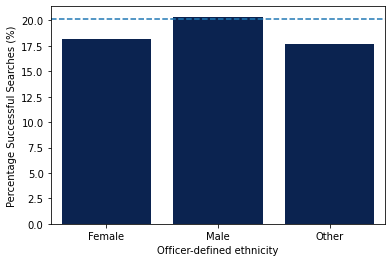

In [292]:
#percengem de success por ethinicty variencia por género
data_sucess_outcomes = df.groupby(['Gender','search_success'])['observation_id'].count()/df.groupby(['Gender'])['observation_id'].count() * 100
data_sucess_outcomes = pd.DataFrame(data_sucess_outcomes).reset_index()
data_sucess_outcomes = data_sucess_outcomes[data_sucess_outcomes['search_success']==True]


f, ax = plt.subplots()
sns.barplot(x='Gender', y='observation_id', data=data_sucess_outcomes ,color="#001f5b", orient='v')
ax.axhline(20.1, ls='--')
ax.set(ylabel="Percentage Successful Searches (%)",xlabel="Officer-defined ethnicity" )

[Text(0, 0.5, 'Percentage Successful Searches (%)'),
 Text(0.5, 0, 'Officer-defined ethnicity')]

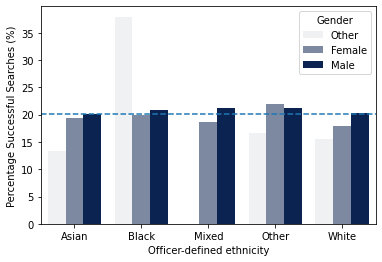

In [293]:
#percengem de success por ethinicty variencia por género
data_sucess_outcomes = df.groupby(['Officer-defined ethnicity','Gender','search_success'])['observation_id'].count()/df.groupby(['Officer-defined ethnicity','Gender'])['observation_id'].count() * 100
data_sucess_outcomes = pd.DataFrame(data_sucess_outcomes).reset_index()
data_sucess_outcomes = data_sucess_outcomes[data_sucess_outcomes['search_success']==True]


f, ax = plt.subplots()
sns.barplot(x='Officer-defined ethnicity', y='observation_id', data=data_sucess_outcomes, hue='Gender' ,color="#001f5b", orient='v',  hue_order=['Other','Female','Male'])
ax.axhline(20.1, ls='--')
ax.set(ylabel="Percentage Successful Searches (%)",xlabel="Officer-defined ethnicity" )

In [294]:
df.groupby(['Officer-defined ethnicity','Gender'])['observation_id'].count() 

Officer-defined ethnicity  Gender
Asian                      Female       811
                           Male       23978
                           Other         30
Black                      Female      1647
                           Male       30874
                           Other         29
Mixed                      Female       177
                           Male        1652
                           Other          1
Other                      Female       474
                           Male        5503
                           Other         12
White                      Female     28274
                           Male      215655
                           Other        200
Name: observation_id, dtype: int64

In [295]:
#percengem de success por ethinicty variencia por género
data_sucess_outcomes = df.groupby(['Officer-defined ethnicity','Gender', 'station','search_success'])['observation_id'].count()/df.groupby(['Officer-defined ethnicity','Gender', 'station'])['observation_id'].count() * 100
data_sucess_outcomes = pd.DataFrame(data_sucess_outcomes).reset_index()
data_sucess_outcomes = data_sucess_outcomes[data_sucess_outcomes['search_success']==True]


# f, ax = plt.subplots()
# sns.barplot(x='Officer-defined ethnicity', y='observation_id', data=data_sucess_outcomes, hue='Gender' ,color="#001f5b", orient='v',  hue_order=['Other','Female','Male'])
# ax.axhline(20.1, ls='--')
# ax.set(ylabel="Percentage Successful Searches (%)",xlabel="Officer-defined ethnicity" )

In [296]:
df.columns

Index(['observation_id', 'Type', 'Date', 'Part of a policing operation',
       'Latitude', 'Longitude', 'Gender', 'Age range',
       'Self-defined ethnicity', 'Officer-defined ethnicity', 'Legislation',
       'Object of search', 'station', 'search_success', 'Day', 'Hour',
       'Minute', 'Time (sin)', 'Time (cos)'],
      dtype='object')

In [297]:
df[df['search_success']==False]

,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,station,search_success,Day,Hour,Minute,Time (sin),Time (cos)
0,34d76816-cfc2-4bdd-b3a2-bf0c40b12689,Person search,2019-12-01 00:00:00,True,50.612228,-4.121710,Male,18-24,Asian/Asian British - Any other Asian background,Asian,Misuse of Drugs Act 1971 (section 23),Controlled drugs,devon-and-cornwall,False,2019-12-01,0.0,0.0,0.000000,0.000000
1,83c87ec1-e6d4-4bbb-8e0c-159516706359,Person search,2019-12-01 00:09:00,True,50.612228,-4.121710,Male,18-24,NaN,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,devon-and-cornwall,False,2019-12-01,0.0,9.0,0.039260,0.039260
2,8c2eae4b-035a-492f-92d6-cd27e6c900a1,Person search,2019-12-01 00:10:00,True,50.612228,-4.121710,Female,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,devon-and-cornwall,False,2019-12-01,0.0,10.0,0.043619,0.043619
3,e63a036a-a728-4efe-8e08-7198f56d6d0a,Person search,2019-12-01 00:10:00,False,50.612228,-4.121710,Male,18-24,NaN,Asian,Misuse of Drugs Act 1971 (section 23),Controlled drugs,devon-and-cornwall,False,2019-12-01,0.0,10.0,0.043619,0.043619
4,40c70aca-1f7f-4efe-8c5b-ade0f2e9937d,Person search,2019-12-01 00:12:00,True,50.368247,-4.126646,Male,18-24,NaN,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,devon-and-cornwall,False,2019-12-01,0.0,12.0,0.052336,0.052336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309311,26bd18b7-ce5b-4ba5-9952-bd3b2b37aa93,Person search,2018-08-28 22:25:00,NaN,51.328831,-1.926610,Female,25-34,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,wiltshire,False,2018-08-28,22.0,25.0,-0.402747,-0.402747
309312,a23dc59d-29fe-48e5-b012-81feb6acfddf,Person search,2018-08-29 02:45:00,NaN,51.328831,-1.926610,Male,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,wiltshire,False,2018-08-29,2.0,45.0,0.659346,0.659346
309314,7c249ab7-d4bf-47ef-86bd-aad51d7d2aab,Person search,2018-08-29 21:10:00,False,51.540219,-1.764708,Male,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,wiltshire,False,2018-08-29,21.0,10.0,-0.675590,-0.675590
309315,4fa54513-20c4-4a53-a5db-8a4bb85b1e32,Person search,2018-08-29 21:15:00,False,51.540219,-1.764708,Male,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,wiltshire,False,2018-08-29,21.0,15.0,-0.659346,-0.659346


[Text(0, 0.5, 'Percentage Successful Searches (%)'),
 Text(0.5, 0, 'Officer-defined ethnicity')]

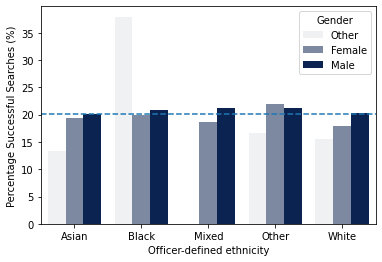

In [298]:
#percengem de success por ethinicty variencia por género
data_sucess_outcomes = df.groupby(['Officer-defined ethnicity','Gender','search_success'])['observation_id'].count()/df.groupby(['Officer-defined ethnicity','Gender'])['observation_id'].count() * 100
data_sucess_outcomes = pd.DataFrame(data_sucess_outcomes).reset_index()
data_sucess_outcomes = data_sucess_outcomes[data_sucess_outcomes['search_success']==True]


f, ax = plt.subplots()
sns.barplot(x='Officer-defined ethnicity', y='observation_id', hue='Gender', data=data_sucess_outcomes, color="#001f5b", orient='v',  hue_order=['Other','Female','Male'])
ax.axhline(20.1, ls='--')
ax.set(ylabel="Percentage Successful Searches (%)",xlabel="Officer-defined ethnicity" )

In [299]:
def clean_df_time(df_):
    # fill null values with average from other wind towers
    df = df_.copy()
    df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)
    df = df.set_index(['Date'])
    return df 

df = clean_df_time(df)
df_1 = clean_df_time(df_1)
df_final = clean_df_time(df_final)

Text(0, 0.5, 'Count of observations')

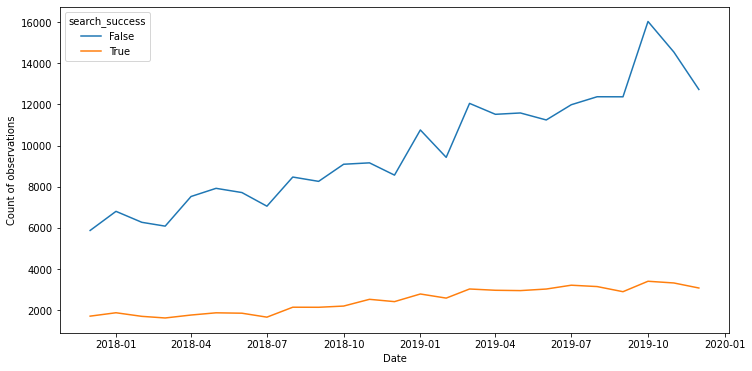

In [300]:
data_dates_count = df.groupby('search_success').resample('M').count()['observation_id']

data_dates_count = pd.DataFrame(data_dates_count)

data_dates_count = data_dates_count.reset_index()
data_dates_count['Date']=pd.to_datetime(data_dates_count.Date.astype(str).str[0:7]+'-01')

fig, ax1 = plt.subplots(figsize=(12,6))

sns.lineplot(data=data_dates_count, x="Date", y="observation_id", hue='search_success')
ax1.set_xlabel('Date')
ax1.set_ylabel('Count of observations')

In [ ]:
sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True)
df_plot = df_filterstations.groupby(['search_success', 'station']).size().reset_index().pivot(columns='search_success', index='station', values=0)
df_plot_graphic[False] = df_plot[False]/(df_plot[False]+df_plot[True])*100
df_plot_graphic[True] = df_plot[True]/(df_plot[False]+df_plot[True])*100
df_plot_graphic.plot(kind='bar', stacked=True, color=["#7d89a1","#001f5b" ])
plt.ylabel("Percentage Successful Searches (%)", fontsize=10)
plt.xlabel("Station", fontsize=10)
plt.title('Training Data', fontsize=10) 


df_plot_1 = df_1_filterstations.groupby(['search_success', 'station']).size().reset_index().pivot(columns='search_success', index='station', values=0)
df_plot_1_graphic[False] = df_plot_1[False]/(df_plot_1[False]+df_plot_1[True])*100
df_plot_1_graphic[True] = df_plot_1[True]/(df_plot_1[False]+df_plot_1[True])*100
df_plot_1_graphic.plot(kind='bar', stacked=True , color=["#7d89a1","#001f5b" ])
plt.ylabel("Percentage Successful Searches (%)", fontsize=10)
plt.xlabel("Station", fontsize=10)
plt.title('Test set 1', fontsize=10) 



    search_success     Date  observation_id
0            False  2017-12            5872
1            False  2018-01            6801
2            False  2018-02            6268
3            False  2018-03            6082
4            False  2018-04            7523
..             ...      ...             ...
59            True  2020-03             179
60            True  2020-04             167
61            True  2020-05             191
62            True  2020-06             179
63            True  2020-07              23

[64 rows x 3 columns]
search_success  False  True 
Date                        
2017-12          5872   1706
2018-01          6801   1871
2018-02          6268   1696
2018-03          6082   1617
2018-04          7523   1760
2018-05          7920   1868
2018-06          7715   1849
2018-07          7052   1657
2018-08          8469   2140
2018-09          8259   2137
2018-10          9091   2196
2018-11          9159   2524
2018-12          8562   2412
2019-01       

Text(0.5, 1.0, 'Training, Test set 1 and Test set 2')

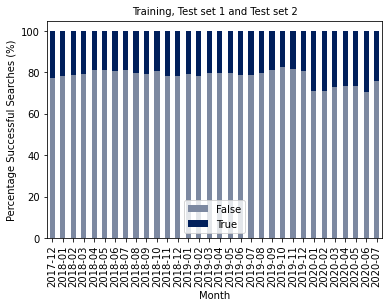

In [354]:
data_dates_count = df_final.groupby('search_success').resample('M').count()['observation_id'].reset_index()
data_dates_count['Date'] = pd.to_datetime(data_dates_count['Date']).dt.to_period('M')
print(data_dates_count)

df_plot_1 = data_dates_count.pivot(columns='search_success', index='Date', values='observation_id')
print(df_plot_1)
df_plot_1_graphic =  pd.DataFrame([])
df_plot_1_graphic[False] = df_plot_1[False]/(df_plot_1[False]+df_plot_1[True])*100
df_plot_1_graphic[True] = df_plot_1[True]/(df_plot_1[False]+df_plot_1[True])*100

print(df_plot_1_graphic)
df_plot_1_graphic.plot(kind='bar', stacked=True , color=["#7d89a1","#001f5b" ])
plt.ylabel("Percentage Successful Searches (%)", fontsize=10)
plt.xlabel("Month", fontsize=10)
plt.title('Training, Test set 1 and Test set 2', fontsize=10) 

Text(0, 0.5, 'Count of observations')

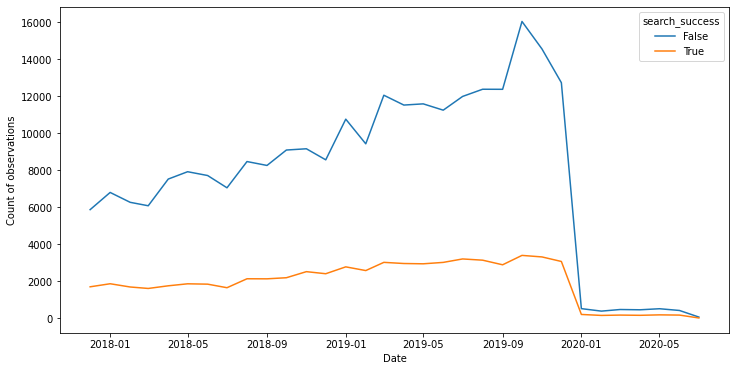

In [301]:
data_dates_count = df_final.groupby('search_success').resample('M').count()['observation_id']
df_plot_1_graphic[False] = df_plot_1[False]/(df_plot_1[False]+df_plot_1[True])*100
df_plot_1_graphic[True] = df_plot_1[True]/(df_plot_1[False]+df_plot_1[True])*100

data_dates_count = pd.DataFrame(data_dates_count)

data_dates_count = data_dates_count.reset_index()
data_dates_count['Date']=pd.to_datetime(data_dates_count.Date.astype(str).str[0:7]+'-01')

fig, ax1 = plt.subplots(figsize=(12,6))

sns.lineplot(data=data_dates_count, x="Date", y="observation_id", hue='search_success')
ax1.set_xlabel('Date')
ax1.set_ylabel('Count of observations')

Text(0, 0.5, 'Count of observations')

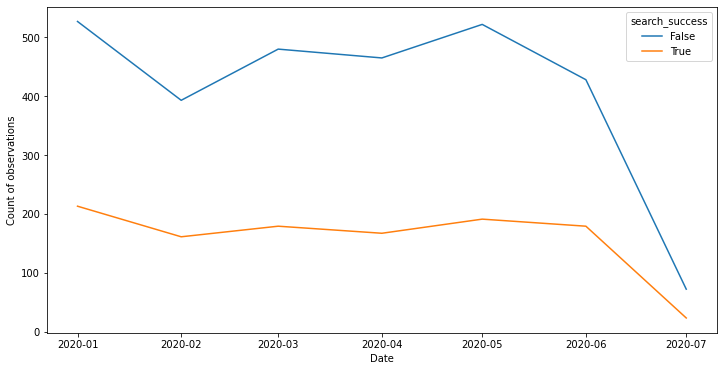

In [302]:
data_dates_count = df_1.groupby('search_success').resample('M').count()['observation_id']

data_dates_count = pd.DataFrame(data_dates_count)

data_dates_count = data_dates_count.reset_index()
data_dates_count['Date']=pd.to_datetime(data_dates_count.Date.astype(str).str[0:7]+'-01')

fig, ax1 = plt.subplots(figsize=(12,6))

sns.lineplot(data=data_dates_count, x="Date", y="observation_id", hue='search_success')
ax1.set_xlabel('Date')
ax1.set_ylabel('Count of observations')

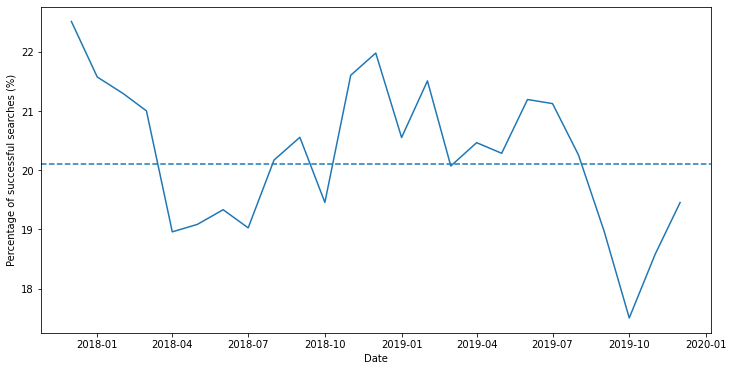

In [303]:
data_dates_count = df.groupby('search_success').resample('M', convention='start').count()['observation_id']/df.resample('M', convention='start').count()['observation_id']
data_dates_count = data_dates_count.reset_index()
data_dates_count['Date']=pd.to_datetime(data_dates_count.Date.astype(str).str[0:7]+'-01')
data_dates_count = data_dates_count[data_dates_count['search_success']==True]
data_dates_count['observation_id'] = data_dates_count['observation_id'] *100


fig, ax1 = plt.subplots(figsize=(12,6))

sns.lineplot(data=data_dates_count, x="Date", y="observation_id", hue='search_success')
ax1.axhline(20.1, ls='--')
ax1.set_xlabel('Date')
ax1.set_ylabel('Percentage of successful searches (%)')

ax1.get_legend().remove()

In [304]:
mean_success_test1 = len(df_1[df_1['search_success']==True])/len(df_1)*100

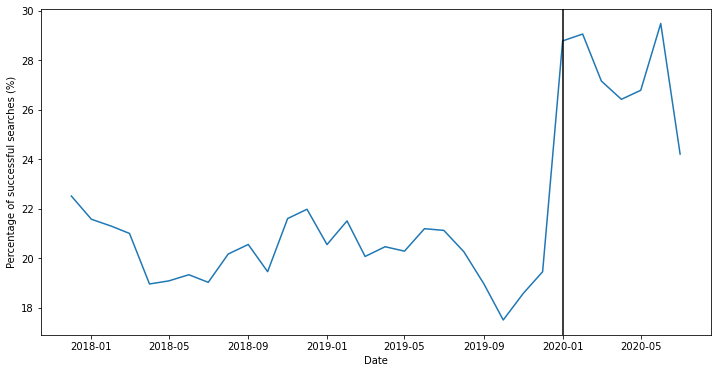

In [305]:
data_dates_count = df_final.groupby('search_success').resample('M', convention='start').count()['observation_id']/df_final.resample('M', convention='start').count()['observation_id']
data_dates_count = data_dates_count.reset_index()
data_dates_count['Date']=pd.to_datetime(data_dates_count.Date.astype(str).str[0:7]+'-01')
data_dates_count = data_dates_count[data_dates_count['search_success']==True]
data_dates_count['observation_id'] = data_dates_count['observation_id'] *100


fig, ax1 = plt.subplots(figsize=(12,6))

sns.lineplot(data=data_dates_count, x="Date", y="observation_id", hue='search_success')
# ax1.axhline(20.1, ls='--')
# ax1.axhline(mean_success_test1, xmin=pd.to_datetime('2020-03-01'), ls='--')
ax1.axvline(pd.to_datetime('2020-01-01'), color='k')
ax1.set_xlabel('Date')
ax1.set_ylabel('Percentage of successful searches (%)')

ax1.get_legend().remove()

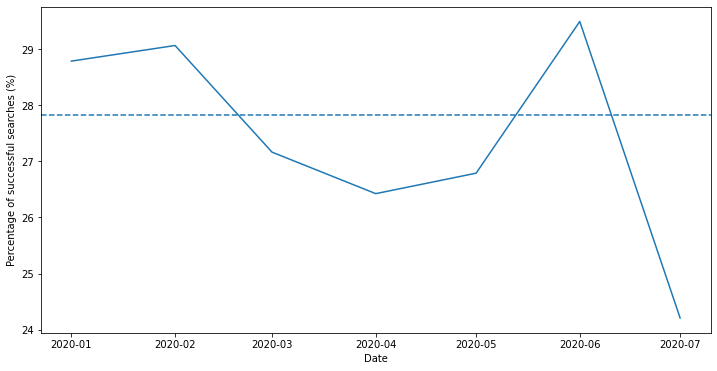

In [307]:

data_dates_count = df_1.groupby('search_success').resample('M', convention='start').count()['observation_id']/df_1.resample('M', convention='start').count()['observation_id']
data_dates_count = data_dates_count.reset_index()


data_dates_count['Date']=pd.to_datetime(data_dates_count.Date.astype(str).str[0:7]+'-01')
data_dates_count = data_dates_count[data_dates_count['search_success']==True]
data_dates_count['observation_id'] = data_dates_count['observation_id'] *100

fig, ax1 = plt.subplots(figsize=(12,6))

sns.lineplot(data=data_dates_count, x="Date", y="observation_id", hue='search_success')
ax1.axhline(mean_success_test1, ls='--')
ax1.set_xlabel('Date')
ax1.set_ylabel('Percentage of successful searches (%)')

ax1.get_legend().remove()

In [308]:
from sklearn.metrics import precision_score, recall_score, precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

# Predicted vs real - Test set 1

In [309]:
def verify_retrieve_rates(X_test, y_true, y_test, sensitive_column, max_diff= 0.10):

    sensitive_column = sensitive_column
    max_diff = max_diff
    sensitive_classes = X_test[sensitive_column].unique()

    precisions={}
    for value in sensitive_classes:
        mask = X_test[sensitive_column] == value
        precisions[value]=recall_score(y_true[mask], y_test[mask], pos_label=True)
    rate_diff = np.max(list(precisions.values())) - np.min(list(precisions.values()))
    if rate_diff > max_diff:
        return False, rate_diff,  precisions
    else:
        return True, rate_diff

In [310]:

def plot_roc_curve(roc_auc, fpr, tpr):
    # Function to plot ROC Curve
    # Note: this is ALL just matplotlib stuff, nothing scientific about it! 
    
    # Inputs: 
    #     roc_auc - AU ROC value (float)
    #     fpr - false positive rate (output of roc_curve()) array
    #     tpr - true positive rate (output of roc_curve()) array
    
    plt.figure(figsize=(8,6))
    lw = 2
    plt.plot(fpr, tpr, color='orange', lw=lw, label='ROC curve (AUROC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='random')
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.grid()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

precision 0.391304347826087
recall 0.03234501347708895
f1 0.05975103734439834
roc_auc 0.5064738576218143


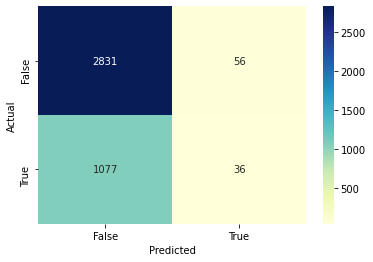

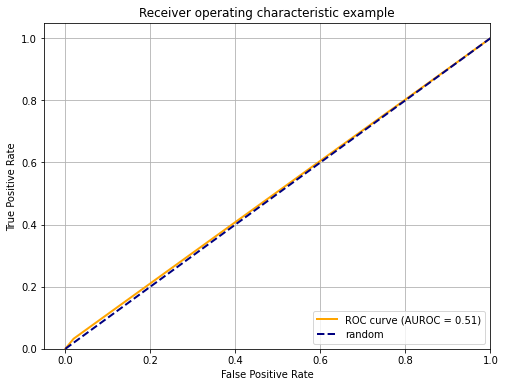

Officer-defined ethnicity (True, 0.045627376425855515)
Age range (True, 0.04927536231884058)
Gender (True, 0.03557312252964427)
Stations (False, 0.11038961038961038, {'nottinghamshire': 0.0, 'city-of-london': 0.11038961038961038, 'durham': 0.007194244604316547, 'cambridgeshire': 0.0})
Combine (True, 0.05157593123209169)


In [311]:
#predicted vs real Test 1
y_pred =df_1['predicted_outcome']
y_test =df_1['search_success']

precision, recall, thresholds = precision_recall_curve( y_test, y_pred , pos_label=True)



precision = precision[:-1][1]
recall = recall[:-1][1]
f1_score_ = f1_score( y_test, y_pred, pos_label=True)
roc_auc_score_ = roc_auc_score(y_true=y_test, y_score=y_pred)
print("precision", precision)
print("recall", recall)
print('f1',f1_score_)
print('roc_auc',  roc_auc_score_)


confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, cmap="YlGnBu", fmt="2")

fpr, tpr, thresholds = roc_curve( y_test, y_pred , pos_label=True)
plot_roc_curve(roc_auc_score_, fpr, tpr)

target = 'search_success'
X_test, y_test= df_1.drop(columns=[target]), df_1[target] 

print('Officer-defined ethnicity', verify_retrieve_rates(X_test, y_test, y_pred, sensitive_column ='Officer-defined ethnicity', max_diff = 0.10))
print('Age range', verify_retrieve_rates(X_test, y_test, y_pred, sensitive_column ='Age range', max_diff = 0.10))
print('Gender', verify_retrieve_rates(X_test, y_test, y_pred, sensitive_column ='Gender', max_diff = 0.10))
print('Stations', verify_retrieve_rates(X_test, y_test, y_pred, sensitive_column ='station', max_diff = 0.10))

X_test['combine'] = X_test['Officer-defined ethnicity'] +' ' + X_test['Age range']+' ' + X_test['station']
X_test['combine'] = X_test['Officer-defined ethnicity'] +' ' + X_test['Gender']
print('Combine', verify_retrieve_rates(X_test, y_test, y_pred, sensitive_column ='combine', max_diff = 0.10))

['Controlled drugs',
 'Offensive weapons',
 'Stolen goods',
 'Article for use in theft',
 'Articles for use in criminal damage',
 'Evidence of offences under the Act',
 'Firearms',
 'Fireworks',
 'Game or poaching equipment']

In [316]:
# #predicted vs real Test 1

# for i in list(df_1['Object of search'].unique()):
#     print(i)
#     df_1_filtered = df_1[df_1['Object of search'] == i]
#     y_pred =df_1_filtered['predicted_outcome']
#     y_test =df_1_filtered['search_success']

#     precision, recall, thresholds = precision_recall_curve( y_test, y_pred , pos_label=True)


#     precision = precision[:-1][1]
#     recall = recall[:-1][1]
#     f1_score_ = f1_score( y_test, y_pred, pos_label=True)
#     roc_auc_score_ = roc_auc_score(y_test, y_pred)
#     print("precision", precision)
#     print("recall", recall)
#     print('f1',f1_score_)
#     print('roc_auc',  roc_auc_score_)


#     confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
#     sns.heatmap(confusion_matrix, annot=True, cmap="YlGnBu", fmt="2")
#     plt.show()

False positives Officer-defined ethnicity  Gender  search_success
White                      Male    False             56
Name: observation_id, dtype: int64
False negatives Officer-defined ethnicity  Gender  search_success
Asian                      Female  True                2
                           Male    True              111
Black                      Female  True                3
                           Male    True              151
Mixed                      Female  True                3
                           Male    True               32
Other                      Female  True                2
                           Male    True               20
White                      Female  True               81
                           Male    True              662
                           Other   True               10
Name: observation_id, dtype: int64


In [312]:
#  for i in 
#     i =  'Offensive weapons'
#     df_1_filtered = df_1[df_1['Object of search'] == i]
#     y_pred =df_1_filtered['predicted_outcome']
#     y_test =df_1_filtered['search_success']

#     precision, recall, thresholds = precision_recall_curve( y_test, y_pred , pos_label=True)



#     # precision = precision[:-1][1]
#     # recall = recall[:-1][1]
#     # f1_score_ = f1_score( y_test, y_pred, pos_label=True)
#     # roc_auc_score_ = roc_auc_score(y_test, y_pred)
#     # print("precision", precision)
#     # print("recall", recall)
#     # print('f1',f1_score_) 
#     # print('roc_auc',  roc_auc_score_)


#     confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
#     sns.heatmap(confusion_matrix, annot=True, cmap="YlGnBu", fmt="2")

#     fpr, tpr, thresholds = roc_curve( y_test, y_pred , pos_label=True)
#     plot_roc_curve(roc_auc_score_, fpr, tpr)

In [313]:
df_1['station'].unique()

array(['nottinghamshire', 'city-of-london', 'durham', 'cambridgeshire'],
      dtype=object)

False    2887
True     1113
Name: search_success, dtype: int64


<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

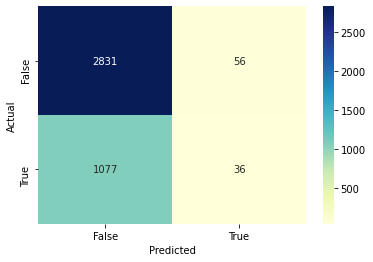

In [314]:
# Per station Analysis
i =  ''
df_1_filtered = df_1.copy()#[df_1['station'] == 'city-of-london']
y_pred =df_1_filtered['predicted_outcome']


y_test =df_1_filtered['search_success']
print(y_test.value_counts())

precision, recall, thresholds = precision_recall_curve( y_test, y_pred , pos_label=True)


# precision = precision[:-1][1]
# recall = recall[:-1][1]
# f1_score_ = f1_score( y_test, y_pred, pos_label=True)
# roc_auc_score_ = roc_auc_score(y_test, y_pred)
# print("precision", precision)
# print("recall", recall)
# print('f1',f1_score_) 
# print('roc_auc',  roc_auc_score_)


confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, cmap="YlGnBu", fmt="2")

# 'nottinghamshire' e 'cambridgeshire' only predicted false
# high nr false positives for 'durham'
# city of london dont have more observation than all of the station - however the performance was better ?? why?? - split between obs true false??




In [315]:
df_1.columns

Index(['observation_id', 'Type', 'Part of a policing operation', 'Latitude',
       'Longitude', 'Gender', 'Age range', 'Self-defined ethnicity',
       'Officer-defined ethnicity', 'Legislation', 'Object of search',
       'station', 'search_success', 'predicted_outcome', 'Day', 'Hour',
       'Minute', 'Time (sin)', 'Time (cos)'],
      dtype='object')

In [317]:
# análise aos falsos positivos e falsos negativos

df_1_filtered = df_1[(df_1.search_success==False)&(df_1.predicted_outcome==True)]
print("False positives", df_1_filtered.groupby(['Officer-defined ethnicity','Gender','search_success'])['observation_id'].count())

df_1_filtered = df_1[(df_1.search_success==True)&(df_1.predicted_outcome==False)]
print("False negatives", df_1_filtered.groupby(['Officer-defined ethnicity','Gender','search_success'])['observation_id'].count())

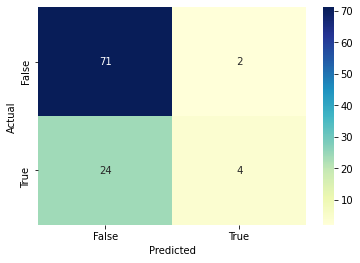

<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

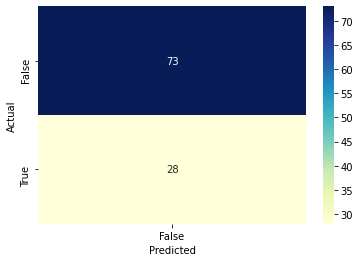

In [319]:
# Observations in test 1 and 2

In [318]:
df_2.outcome.value_counts()

False    3926
True       77
Name: outcome, dtype: int64